In [1]:
%load_ext nb_black

# Library to suppress warnings or deprecation notes
import warnings

warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import pdist

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

<IPython.core.display.Javascript object>

In [2]:
data = pd.read_excel("Credit+Card+Customer+Data.xlsx")

<IPython.core.display.Javascript object>

In [3]:
data.shape

(660, 7)

<IPython.core.display.Javascript object>

In [4]:
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


<IPython.core.display.Javascript object>

- The bank's overall goal in this case is to in the end, be able to better service their customer base.
- This is done by upgrading the customer service experience, and identifying customers better in order to create better maketing campaigns which target them. By grouping customers together better, the bank will also earn more income and be able to upsell to specific customers.
- We will group customers together based on the data provided by using K-means Clustering and Hierarchical Clustering.
- Before we can cluster the customer data base, we will need to do a few things though, including taking a better look at the data visually to see what we are working with. 

In [5]:
# fixing column names
data.columns = [c.replace(" ", "_") for c in data.columns]

<IPython.core.display.Javascript object>

In [6]:
# let's look at the structure of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer_Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

### We do not need the serial number column for analysis so we will drop it, we will be dropping the customer key as well since it won't mean much once we scale the data

In [7]:
data.drop("Sl_No", axis=1, inplace=True)
data.drop("Customer_Key", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [8]:
# let's check for duplicate observations
data.duplicated().sum()

11

<IPython.core.display.Javascript object>

In [9]:
data = data[(~data.duplicated())].copy()

<IPython.core.display.Javascript object>

- These 'duplicated' rows are not real duplicates. In a banking situation like this, it is entirely possible that a customer could be represented twice depending their banking siutation. This line of code tells the dataset that these are not actually duplicates.

In [10]:
data.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,649.000000,649.000000,649.000000,649.000000,649.000000
mean,34878.274268,4.708783,2.397535,2.624037,3.590139
std,37813.736638,2.173763,1.625148,2.952888,2.877911
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,11000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,49000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


<IPython.core.display.Javascript object>

### Observations

- There are 660 customers
- Average Credit Limit is 34.5k
- Average Total Credit Cards is close to 5
- Average Total Visits to the Bank, and Online Log Ins are both close to 2.5 in a year
- Average Total Calls Made in a year is close to 3.5
- 0's being present in the visits and calls columns indicate some customers had little to no interaction with the bank

### I want to take a look at the customers who had some form of no interaction with the bank

In [11]:
(data.Total_visits_bank == 0).sum()

97

<IPython.core.display.Javascript object>

In [12]:
# let's check the 100 customers who did not visit the bank in person
data[(data.Total_visits_bank == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,50000,3,0,10,9
4,100000,6,0,12,3
5,20000,3,0,1,8
6,100000,5,0,11,2
7,15000,3,0,1,1
...,...,...,...,...,...
645,171000,10,0,15,0
646,186000,7,0,8,1
647,183000,9,0,9,2
653,95000,10,0,15,1


<IPython.core.display.Javascript object>

In [13]:
(data.Total_visits_online == 0).sum()

141

<IPython.core.display.Javascript object>

In [14]:
# let's check the 144 customers who did not log into the bank online
data[(data.Total_visits_online == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
228,10000,7,2,0,0
230,17000,4,5,0,2
234,16000,6,5,0,4
235,13000,7,4,0,0
237,8000,6,4,0,4
...,...,...,...,...,...
589,29000,4,5,0,2
600,68000,7,5,0,0
601,33000,5,4,0,2
602,37000,7,4,0,1


<IPython.core.display.Javascript object>

In [15]:
(data.Total_calls_made == 0).sum()

96

<IPython.core.display.Javascript object>

In [16]:
# let's check the 97 customers who did not make a call the entire year
data[(data.Total_calls_made == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
228,10000,7,2,0,0
232,20000,5,4,1,0
233,13000,7,2,1,0
235,13000,7,4,0,0
...,...,...,...,...,...
645,171000,10,0,15,0
648,111000,8,1,7,0
652,156000,8,1,8,0
655,99000,10,1,10,0


<IPython.core.display.Javascript object>

### Because this is a relatively small dataset, I do not believe these 0's are due to error. I truly believe there are customers who do not like to interact with their bank in any way as long as things are going smoothly. Further EDA will help us see if these are outliers however. 

In [17]:
# checking missing values
data.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

- There are no missing values in this dataset

In [18]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

<IPython.core.display.Javascript object>

###  EDA - Univariate Analysis

In [19]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

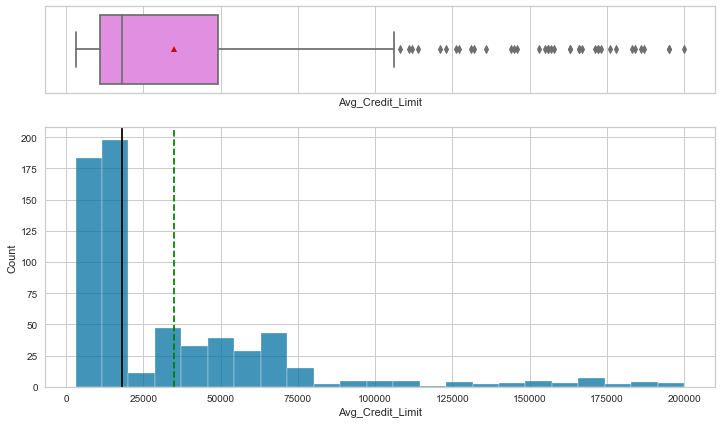

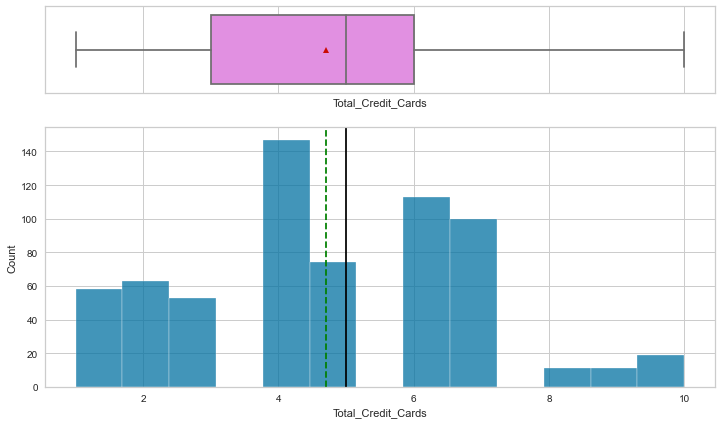

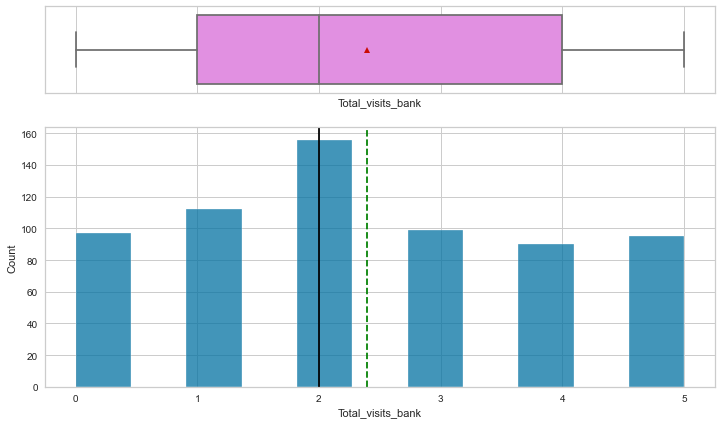

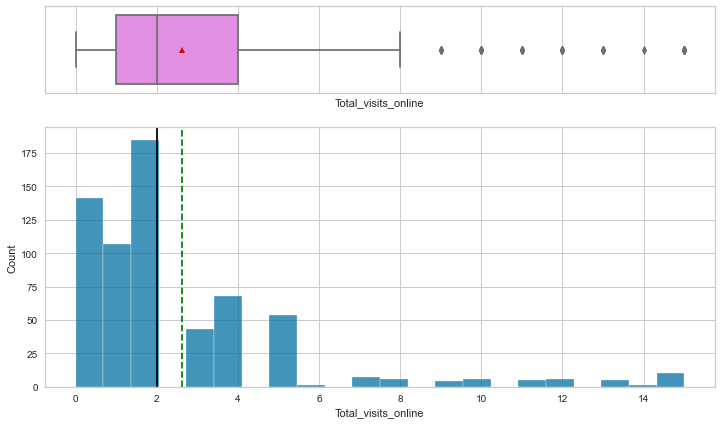

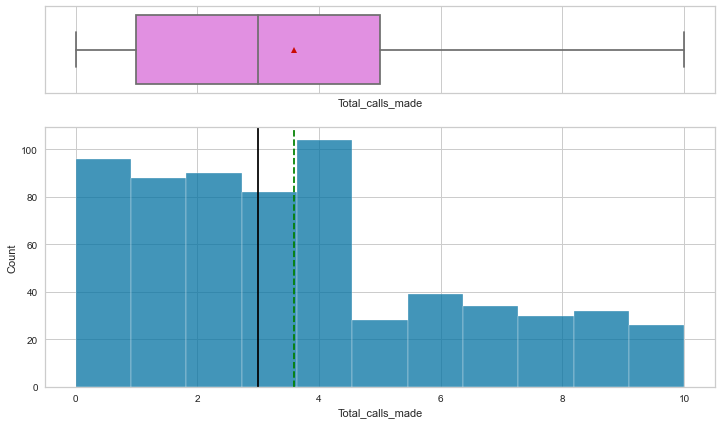

<IPython.core.display.Javascript object>

In [20]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(df, item)

- Average credit limit has a skewed right distribution, with many outliers on the right end. This is why the average is much higher than the median. Every value past 100k is an outlier in this case.
- Total Credit Cards and Total Visits to the Bank (in person) are normally distributed.
- Total Visits Online is also very skewed right, this is most likely something the bank will want to fix, the online service needs to be good enough for people to want to use it. There are outliers present in this column as well.
- Total Calls Made is also skewed right, but not as much, it almost has a uniform distribution. 

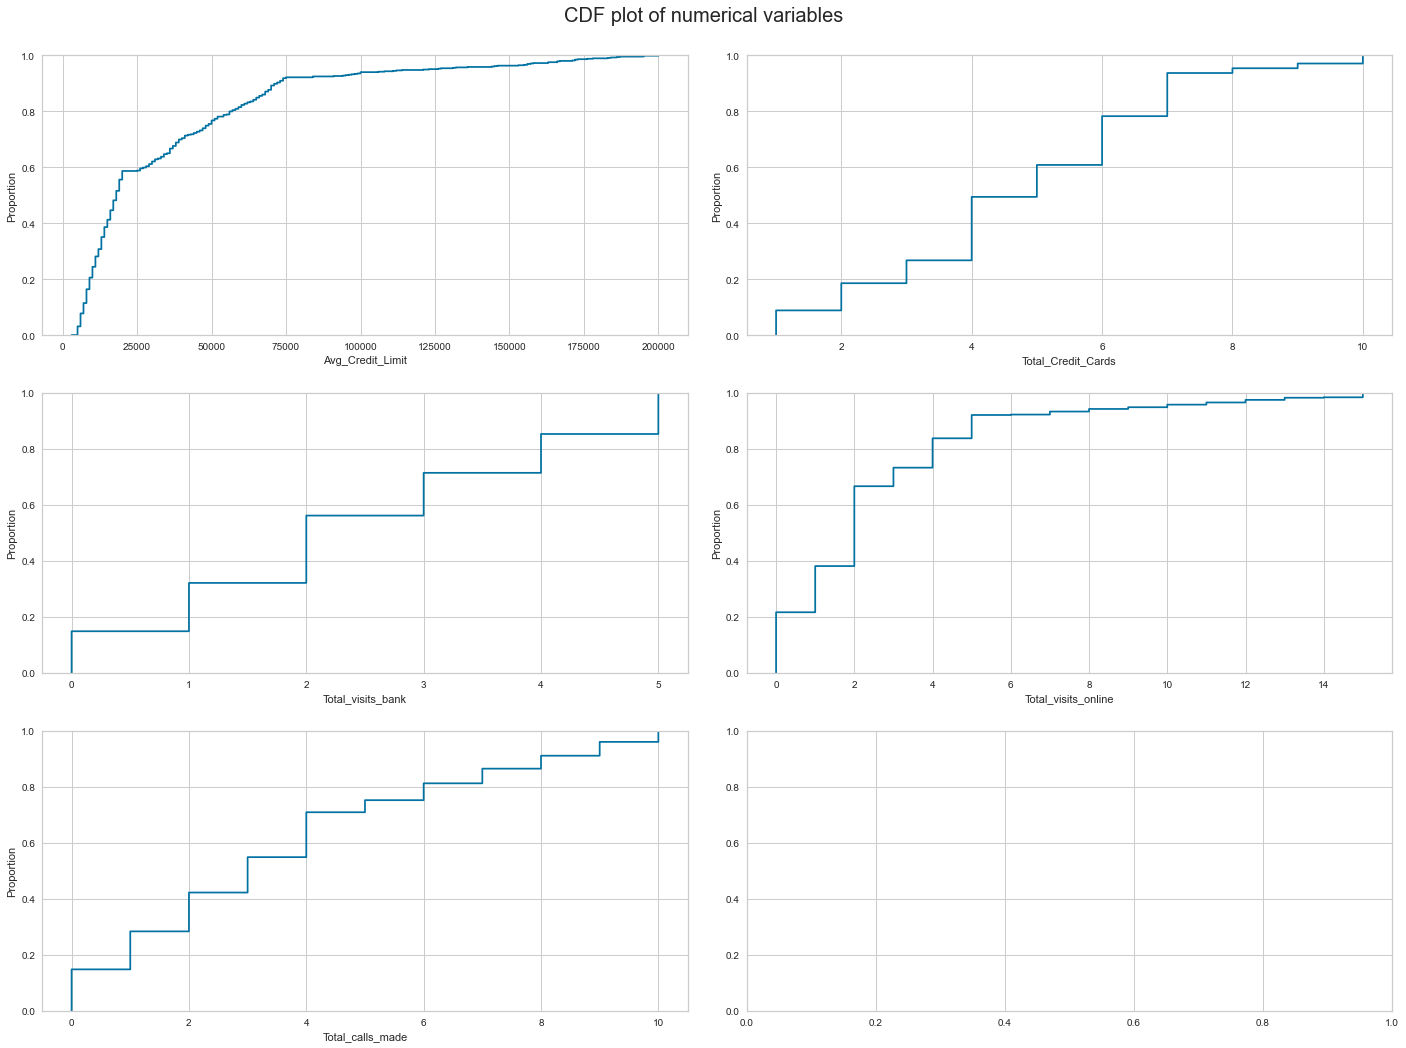

<IPython.core.display.Javascript object>

In [21]:
# cumulative distribution function plot

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0], x=df[num_col[counter]])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1], x=df[num_col[counter]])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

- 90% of customers have a credit limit of 75K or less
- 80% of customers have 6 credit cards or less
- 70% of customers have 3 visits to the bank or less
- 90% of customers have 5 online visits or less

In [22]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

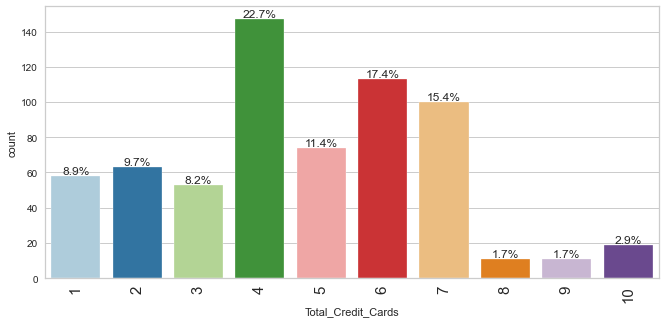

<IPython.core.display.Javascript object>

In [23]:
# let's explore number of credit cards
labeled_barplot(df, "Total_Credit_Cards", perc=True)

- After 7 credit cards, there are not a lot of customers. 

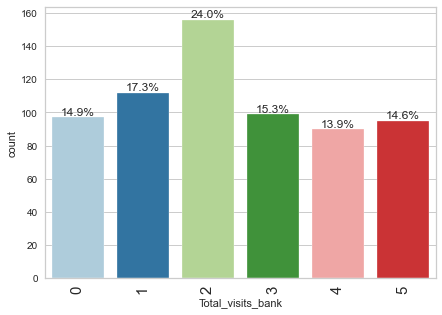

<IPython.core.display.Javascript object>

In [24]:
# let's explore bank visits
labeled_barplot(df, "Total_visits_bank", perc=True)

- 2 visits to the bank a year seems to be the clear highest here, the rest of the values are very uniform. 

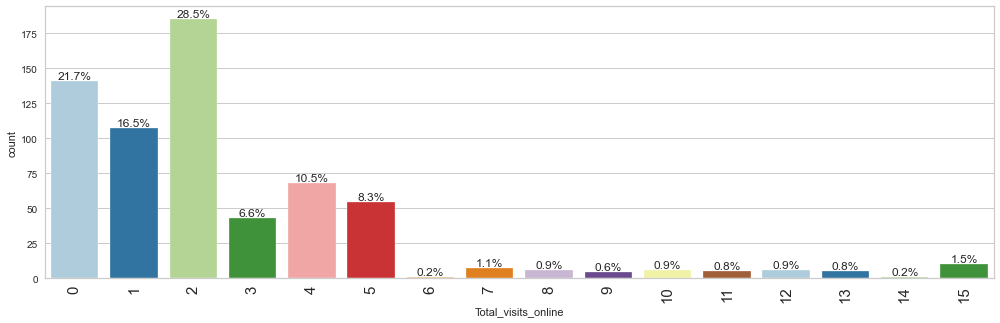

<IPython.core.display.Javascript object>

In [25]:
# let's explore online visits
labeled_barplot(df, "Total_visits_online", perc=True)

- As seen earlier, after 5 visits, the number of customers visiting the website severely drops. 0 visits is our second highest amount.

### EDA - Bivariate Analysis

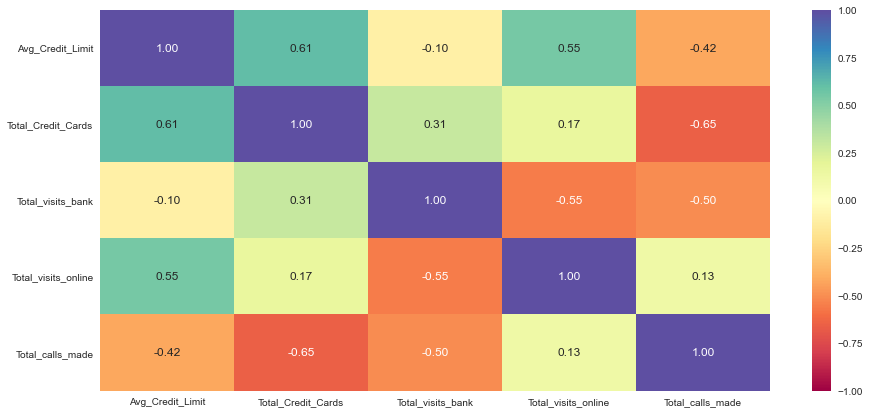

<IPython.core.display.Javascript object>

In [26]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

- No extreme positive correlation between independent variables.
- It seems the higher average credit limit goes up, so do visits online and total credit cards.

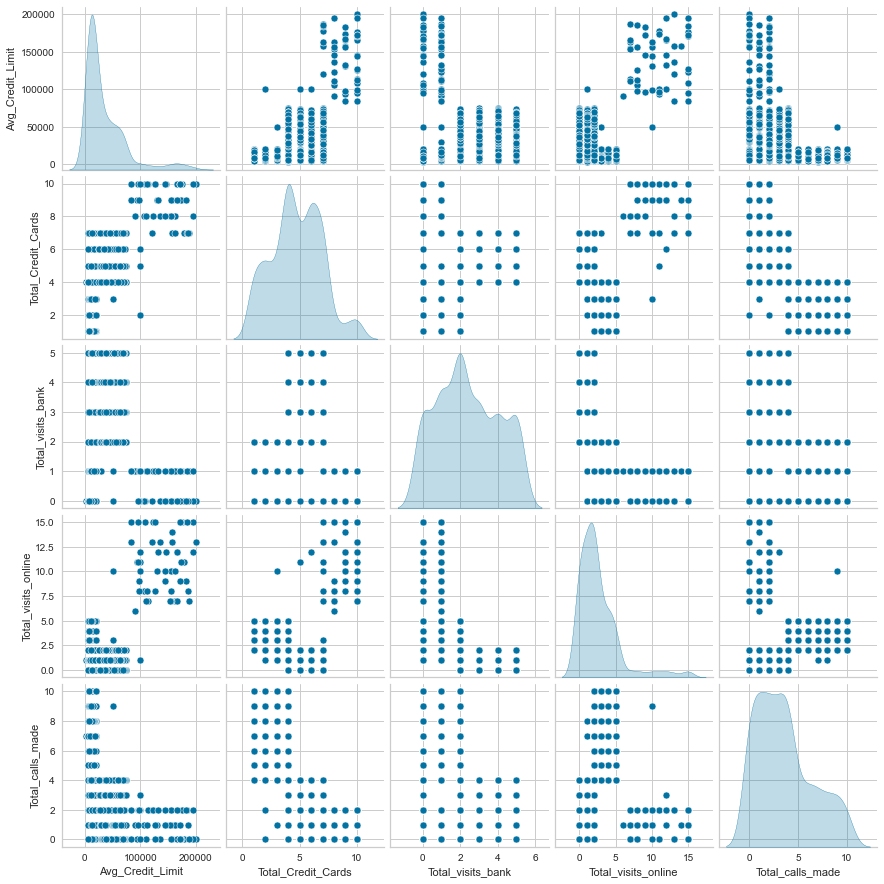

<IPython.core.display.Javascript object>

In [27]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

- Showing alot of what we already know, but it is starting to give me an idea on how many potential clusters there may be based on the data. It seems that higher credit customers will most likely be grouped together. 
- It seems that one group may have a large proportion of customers, due to many customers having a low to mid credit limit. 

### Data Preprocessing

In [28]:
# variables used for clustering
num_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

<IPython.core.display.Javascript object>

- We have already checked for duplicates and dealt with them accordingly.
- There are no missing values in the dataset.
- I am choosing not to treat the outliers, since I believe they will be important to creating my clusters. There are a significant number of outliers in the average credit limit column and setting a cap on these values would not be accurately representing the data. This data comes from the banks systems, if they want real results on their customers then they need to use the data their systems have gathered. 

### Dividing/Scaling My Data

In [29]:
df_Kmeans = data.copy()

<IPython.core.display.Javascript object>

In [30]:
df_Hierarchical = data.copy()

<IPython.core.display.Javascript object>

In [31]:
# scaling the dataset before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

<IPython.core.display.Javascript object>

In [32]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

- I need to copy my data again to ensure that the clusters don't influence each other during K Means and Hierarchical Clustering.

### K Means Clustering

Number of Clusters: 1 	Average Distortion: 2.007896349270688
Number of Clusters: 2 	Average Distortion: 1.4576197022077821
Number of Clusters: 3 	Average Distortion: 1.1434401208195095
Number of Clusters: 4 	Average Distortion: 1.0435538595477063
Number of Clusters: 5 	Average Distortion: 0.988052836262114
Number of Clusters: 6 	Average Distortion: 0.9405015907509096
Number of Clusters: 7 	Average Distortion: 0.9073026049403949
Number of Clusters: 8 	Average Distortion: 0.8867427859070763
Number of Clusters: 9 	Average Distortion: 0.8659493506021165
Number of Clusters: 10 	Average Distortion: 0.8439949891779934
Number of Clusters: 11 	Average Distortion: 0.8202341961165411
Number of Clusters: 12 	Average Distortion: 0.8053173453155681
Number of Clusters: 13 	Average Distortion: 0.7905898262911872
Number of Clusters: 14 	Average Distortion: 0.7704280117568072


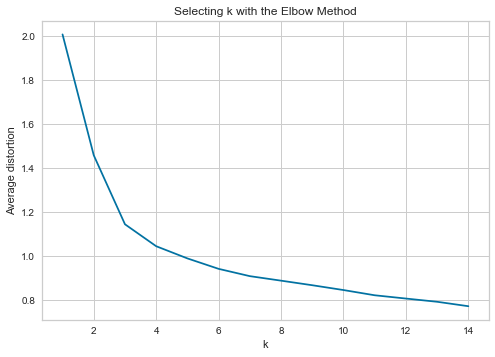

<IPython.core.display.Javascript object>

In [33]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average distortion")
plt.title("Selecting k with the Elbow Method")
plt.show()

- Appropriate K value seems to be 3 or 4 so we will try silhouette scores with both. 

For n_clusters = 2, the silhouette score is 0.41800025566689647)
For n_clusters = 3, the silhouette score is 0.516281010855363)
For n_clusters = 4, the silhouette score is 0.3570238219413198)
For n_clusters = 5, the silhouette score is 0.2723299188401586)
For n_clusters = 6, the silhouette score is 0.2565634143183434)
For n_clusters = 7, the silhouette score is 0.24858598023492512)
For n_clusters = 8, the silhouette score is 0.2254869618550929)
For n_clusters = 9, the silhouette score is 0.21864222989330898)


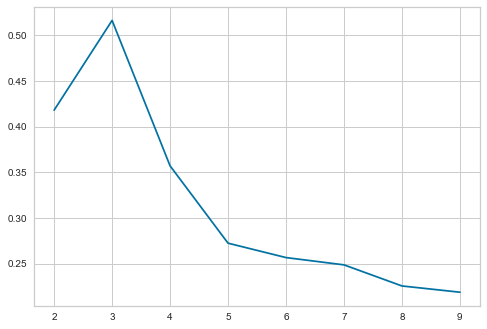

<IPython.core.display.Javascript object>

In [34]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

- It does seem k=3 gives the best silhouette score, I still would like to visualize k=3 and k=4

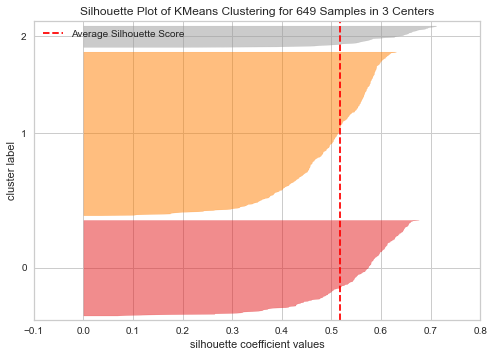

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [35]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

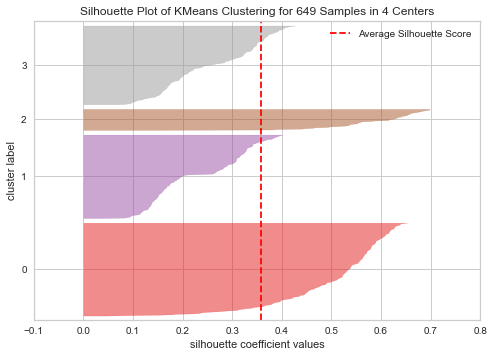

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 649 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

<IPython.core.display.Javascript object>

In [36]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

- We will use 3 as our optimal K. From the elbow plot, I assumed 3 would score much better than 4, which I feel like it has after plotting the silhouette scores. Some of the groups presented in the k=4 graph are varied in performance, so I feel more comfortable choosing 3 as my k.

In [37]:
# let's take 3 as number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [38]:
# adding kmeans cluster labels to the original and scaled dataframes

df_Kmeans["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

<IPython.core.display.Javascript object>

In [39]:
cluster_profile = df_Kmeans.groupby("K_means_segments").mean()

<IPython.core.display.Javascript object>

In [40]:
cluster_profile["count_in_each_segments"] = (
    df_Kmeans.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [41]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_segments,,,,,,
0,141040.000000,8.740000,0.600000,10.900000,1.080000,50
1,34071.428571,5.518519,3.484127,0.981481,1.992063,378
2,12239.819005,2.411765,0.945701,3.561086,6.891403,221


<IPython.core.display.Javascript object>

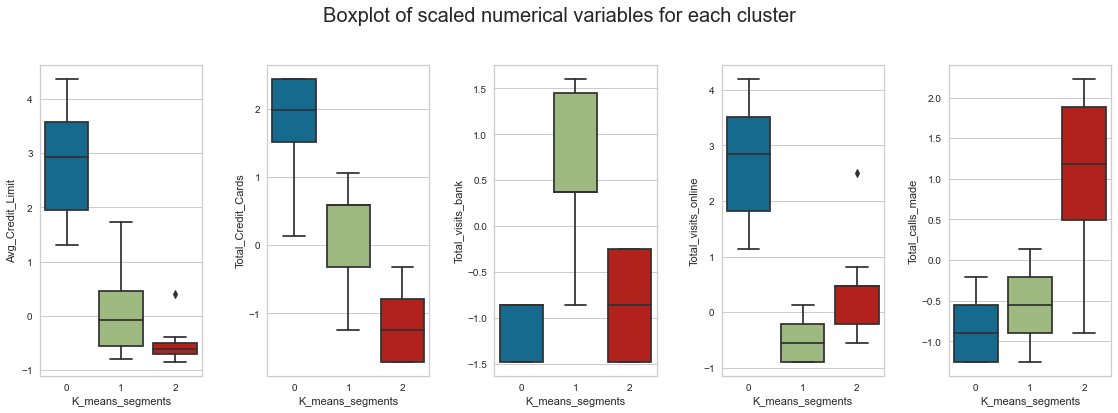

<IPython.core.display.Javascript object>

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["K_means_segments"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

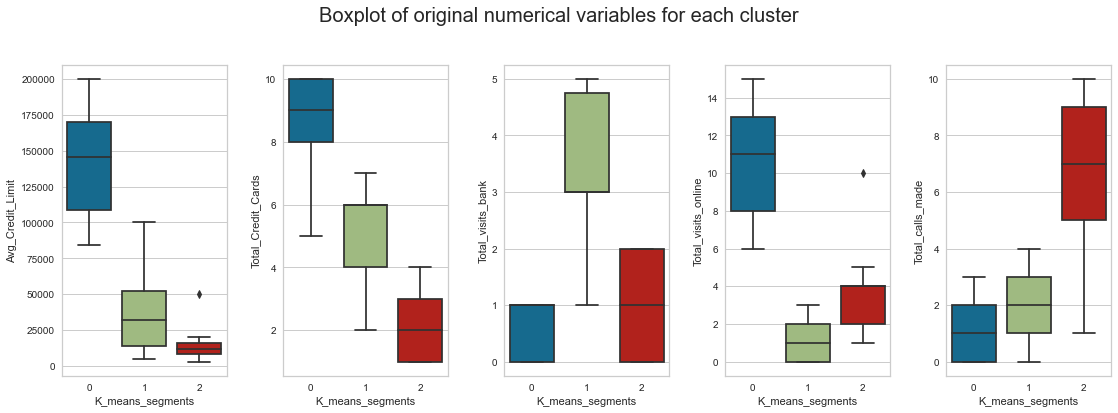

<IPython.core.display.Javascript object>

In [43]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii], y=df_Kmeans[num_col[counter]], x=df_Kmeans["K_means_segments"]
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

- **Cluster 0**:
    - This group has by far the highest average credit limit
    - They also have the most credit cards, and the most visits online.
    - This group however rarely visits the bank in person, and they rarely call the support team. Any marketing done on this group would certainly need to be one by mail or over the internet. 
    - They most likely have higher incomes if they have such high credit limits as well. These are customers the bank has to keep no matter what. 
    - They are also the smallest group by far, with only 50 customers.
   
- **Cluster 1**:
    - This group has the second highest credit limit, with the highest customer having close to a 100k limit. Most customers in this group have around a 30k credit limit. 
    - This group also have the second most amount of credit cards. They have at least 2 and go as high as 7.
    - This group visits the bank in person the most. 
    - This group does not like visiting the bank online.
    - This group makes the second most number of calls. 
    - This group has 378 customers in it, making it the biggest.
    
- **Cluster 2**:
    - This group by far has the lowest credit card averages.
    - This group also has the least amount of credit cards.
    - This group visits the bank in person and online the second most amount of times. 
    - This group by far makes the most calls to the bank.
    - This group has 221 customers in it, making it the second biggest. 

## Business Recommendations

- Cluster 0 consists of high credit customers, so focused marketing campaigns can be done to target customers with higher purchasing power.
- Cluster 0 does not have that many customers in it, so it could be easy to go after all 50 of them. They prefer online communication, so email offers may prove best.
- Cluster 1 consists of customers that are in the middle of many categories, and they prefer in person communication. Marketing products should be offered in physical bank branches to these customers.
- Cluster 2 consists of customers that have low credit averages, but they call into bank support more than any other group, meaning improving the speed and quality of customer support would benefit this group greatly.

## Hierarchical Clustering

In [44]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.8978538751523425.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8837002394146526.
Cophenetic correlation for Euclidean distance and average linkage is 0.9100963201569814.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.9052656121003184.
Cophenetic correlation for Chebyshev distance and single linkage is 0.8118063771075958.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8672376803928954.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9086066909752651.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.88484300133361.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.8652242698029385.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.48890770651760973.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8388700518358664.
Cophenetic cor

<IPython.core.display.Javascript object>

In [45]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9100963201569814, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

- It seems that Euclidian distance would be a good measure to further explore, so I will use that with my different linkage methods going forward. 

**Let's explore different linkage methods with Euclidean distance only.**

In [46]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.8978538751523425.
Cophenetic correlation for complete linkage is 0.8837002394146526.
Cophenetic correlation for average linkage is 0.9100963201569814.
Cophenetic correlation for centroid linkage is 0.907332941987878.
Cophenetic correlation for ward linkage is 0.7576535233745099.
Cophenetic correlation for weighted linkage is 0.9052656121003184.


<IPython.core.display.Javascript object>

In [47]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9100963201569814, which is obtained with average linkage.


<IPython.core.display.Javascript object>

**Observations**

- We see that the cophenetic correlation is maximum with euclidean distance, and average linkage.
- The cophenetic correlation with Chebyshev distance and average linkage is slightly less than the combination with maximum cophenetic correlation. 


**Let's see the dendrograms for the different linkage methods.**

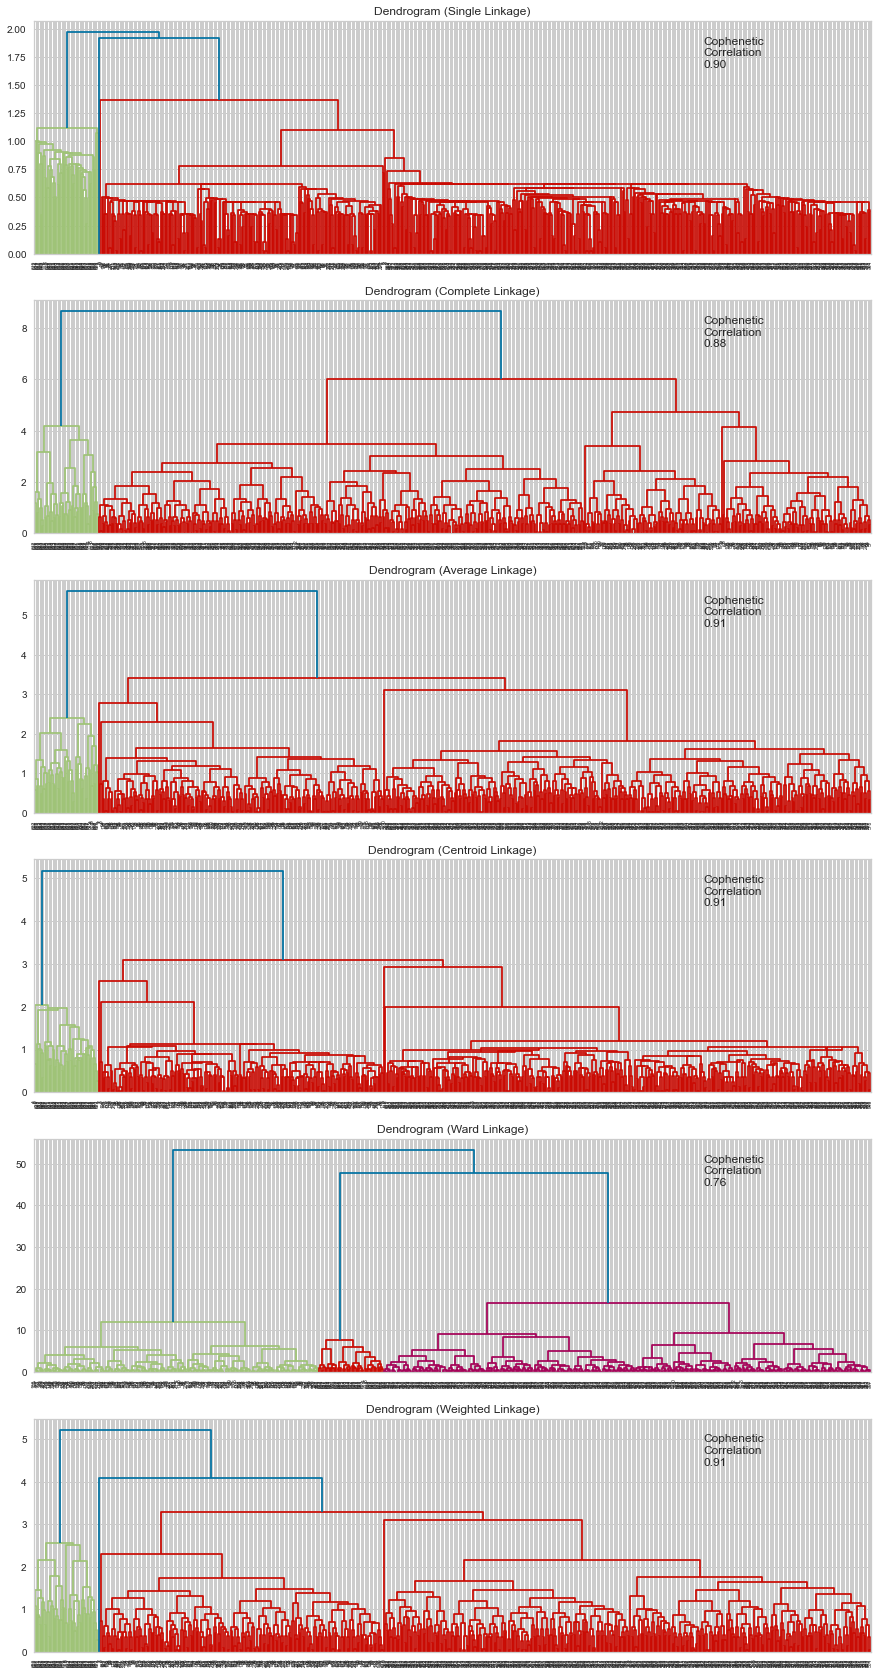

<IPython.core.display.Javascript object>

In [48]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [49]:
# let's create a dataframe to compare cophenetic correlations for each linkage method
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.897854
1,complete,0.883700
2,average,0.910096
3,centroid,0.907333
4,ward,0.757654
5,weighted,0.905266


<IPython.core.display.Javascript object>

**Let's see the dendrogram for Chebyshev and Manhattan distances with average and complete linkage methods (as they gave high cophenetic correlation values).**

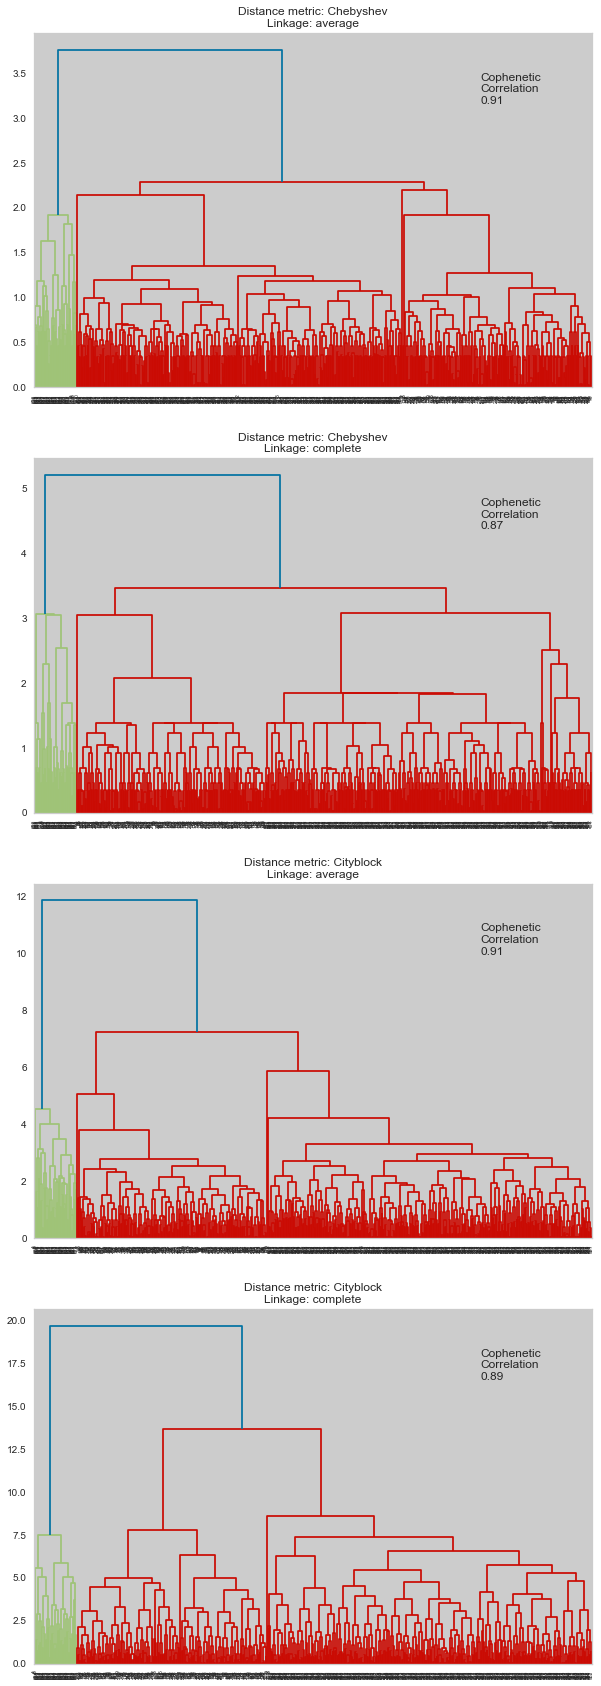

<IPython.core.display.Javascript object>

In [50]:
# list of distance metrics
distance_metrics = ["chebyshev", "cityblock"]

# list of linkage methods
linkage_methods = ["average", "complete"]

# to create a subplot image
fig, axs = plt.subplots(
    len(distance_metrics) + len(distance_metrics), 1, figsize=(10, 30)
)

i = 0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        dendrogram(Z, ax=axs[i])
        axs[i].set_title("Distance metric: {}\nLinkage: {}".format(dm.capitalize(), lm))

        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(
            f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
            (0.80, 0.80),
            xycoords="axes fraction",
        )
        i += 1

**Observations**

- Out of all the dendrograms we saw, it is clear that the dendrogram with Ward linkage gave us separate and distinct clusters. It does not have the best cophenetic correlation but it looks the most distinct. This is what I will choose for further modeling.
- 4 would be the appropriate number of the clusters from the dendrogram with Ward linkage method. I choose 4 due to the fact that one rather large group will get split in two, which I think is appropriate to really group them together well. 

### Creating 3 Clusters

In [51]:
HCmodel = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(n_clusters=4)

<IPython.core.display.Javascript object>

In [52]:
# adding hierarchical cluster labels to the original and scaled dataframes

subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df_Hierarchical["HC_Clusters"] = HCmodel.labels_

<IPython.core.display.Javascript object>

### Cluster Profiling

In [53]:
cluster_profile = df_Hierarchical.groupby("HC_Clusters").mean()

<IPython.core.display.Javascript object>

In [54]:
cluster_profile["count_in_each_segments"] = (
    df_Hierarchical.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

<IPython.core.display.Javascript object>

In [55]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,12239.819005,2.411765,0.945701,3.561086,6.891403,221
1,38732.240437,5.715847,2.508197,0.978142,2.054645,183
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,29697.435897,5.333333,4.400000,0.984615,1.933333,195


<IPython.core.display.Javascript object>

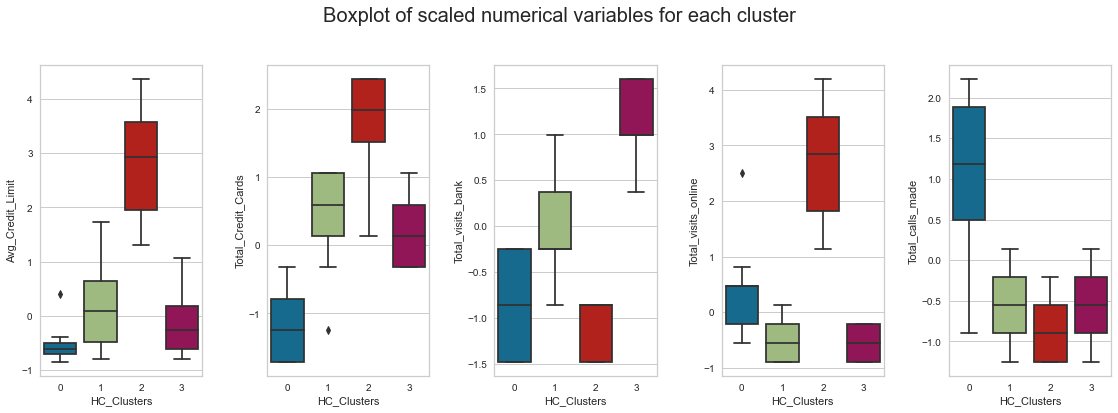

<IPython.core.display.Javascript object>

In [56]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=subset_scaled_df[num_col[counter]],
        x=subset_scaled_df["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

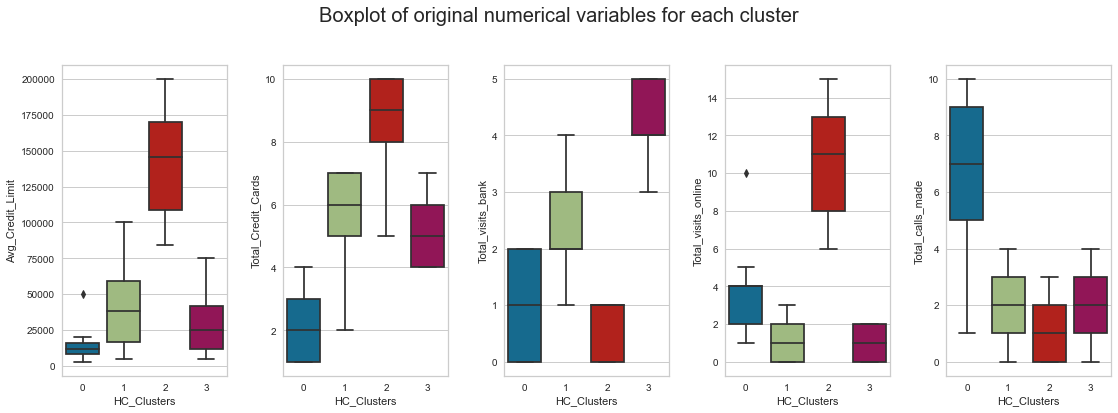

<IPython.core.display.Javascript object>

In [57]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(
        ax=axes[ii],
        y=df_Hierarchical[num_col[counter]],
        x=df_Hierarchical["HC_Clusters"],
    )
    counter = counter + 1

fig.tight_layout(pad=2.0)

## Insights

- **Cluster 0**:
    - This group by far has the lowest credit card averages.
    - This group also has the least amount of credit cards.
    - This group visits the bank online the second most amount of times. 
    - This group by far makes the most calls to the bank.
    - This group has 221 customers in it, making it the biggest.
   
- **Cluster 1**:
    - This group has the second highest credit limit, the second most credit cards, the second most visits to the bank, and the second most calls made.
    - This group has the third most customers, with 183. 
- **Cluster 2**:
    - This group has the highest credit limit by far, the higest credit cards by far, and the highest online visits by far.
    - This is also the smallest group of customers, with 50.
  
- **Cluster 3**:
    - This group visits the bank the most.
    - They are pretty average with other attributes.
    - This group has the second most customers, with 195.

## Business Recommendations

- Cluster 0 consists of customers that have low credit averages, but they call into bank support more than any other group, meaning improving the speed and quality of customer support would benefit this group greatly.
- Cluster 1 consists of customers that are near the top of many categories, and they prefer in person communication. Marketing products should be offered in physical bank branches to these customers.
- Cluster 2 consists of high credit customers, so focused marketing campaigns can be done to target customers with higher purchasing power.
- Cluster 2 does not have that many customers in it, so it could be easy to go after all 50 of them. They prefer online communication, so email offers may prove best.
- Cluster 3 visits the bank in person than any other group. They should be marketed to in person by the bank staff. This group is rather similar to group 1, and many customers could overlap in the two groups in terms of similarities. 

### Comparing Clusters 

- The groups were very similar in both K Means and Hierarchical Clustering, because the customer data is very grouped itself. 
- One group of customers are those who have very high credit limits and a high number of credit cards. These customers also likely to do their business online. This group was represented by the same 50 customers in both K Means and Hierarchical Clustering. 
- One group of customers is the opposite, they have very low credit limits, and tend to make a high number of phone calls. They also like to do business online rather than in the branch.
- The remaining customers is where it gets different. When I split them into two groups (as i did during hierarchical clustering) they are still very similar groups but they have some key differences. One group takes a bulk of customers who have a higher credit limit, while the other has a slightly lower limit, but makes way more visits into the bank. The most in fact. 
- I would recommend to the marketing department to use K Means in this situation as it gives them three, very distinct groups to advertise to. 

### Final Recommendations

- First, I would recommend if the bank does this in the future, they use K Means as a default clustering technique. It took the computer much less time to get the final results of that than it did with Hierarchical Clustering. 
- Lower limit customers, who most likely earn less as well, utilize the phone service of the bank. Improving the quality of calls and training of staff in the call centers could improve sales. Call center staff could learn to upsell customers when a product that would benefit the customer becomes an option.
- Higher limit customers prefer online communication. Sending offers over email, or creating incentives for them to come into the branch could gain the bank more income. High level customers have more money to spend and that means more fees and everything else for the bank. Plus, there are only 50 of these customers. It is not hard to personally market to 50 people. 
- The middle limit customers tend to visit the bank in person more often. They have a higher credit limit than the group with the lowest level of credit limit, but they also have a much lower credit limit then the group with a high credit limit. They will be best reached by personable bank workers. Placing fliers and whatever else around the teller stations could create business all on its own. 